## Import Statements

In [1]:
import eleanor

import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
plt.rcParams['figure.dpi'] = 300

import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = 5

import pandas as pd
import pyvo as vo
from ztfquery import lightcurve

---
## TESS

In [2]:
def get_tess(tic, sec):
    tess = eleanor.Source(tic=tic, sector=sec)

    print('\nTESS: Found TIC {0} (Gaia DR2 {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'.format(tess.tic, tess.gaia, tess.tess_mag, tess.coords[0], tess.coords[1]))

    return tess

In [3]:
def lc_tess(tess):
    data = eleanor.TargetData(tess, height=15, width=15, bkg_size=31, do_pca=True, regressors='corner')

    plt.figure(figsize=(15,5))

    # plt.scatter(data.time, data.pca_flux/np.nanmedian(data.pca_flux), label='PCA', s=10)  # no quality mask
    q = data.quality == 0
    plt.scatter(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), label='PCA (q == 0)', s=10)

    plt.ylabel('Normalized Flux')
    plt.xlabel('Time [BJD - 2457000]')
    plt.title('TESS: TIC ' + str(tess.tic))
    plt.legend(loc='upper left')
    plt.show()

---
## Gaia

In [4]:
def get_gaia(ra, dec):
    coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
    radius = u.Quantity(1.0, u.arcsec)

    job = Gaia.cone_search_async(coord, radius)
    results = job.get_results()

    gaia = int(str(results[0][1])[8:])
    print('\nGAIA: ' + str(gaia))

    query_str = "SELECT source.* " + "FROM gaiadr3.gaia_source as source " + "WHERE source.source_id='" + str(gaia) + "'"
    job = Gaia.launch_job(query_str)
    results = job.get_results()

    if results['has_epoch_photometry'][0]:
        print('GAIA: Has epoch photometry.')
        return gaia
    else:
        print('GAIA: Does not have epoch photometry.')
        return None

In [14]:
def lc_gaia(gaia, star):
    datalink = Gaia.load_data(ids=gaia, data_release = 'Gaia DR3', data_structure = 'COMBINED', retrieval_type = 'EPOCH_PHOTOMETRY', valid_data=True)

    dl_key = [i for i in datalink.keys()][0]
    print(f'The following Datalink product has been downloaded: * {dl_key}')

    epoch = datalink[dl_key][0].to_table().to_pandas()
    # g = epoch[epoch['band'] == 'G']
    rp = epoch[epoch['band'] == 'RP']
    bp = epoch[epoch['band'] == 'BP']

    rp['magerr'] = np.divide(rp['flux_error'], rp['flux'])
    bp['magerr'] = np.divide(bp['flux_error'], bp['flux'])

    plt.figure(figsize=(15,5))

    # plt.scatter(g['time'], g['mag'], label='G', color='green', s=10)
    plt.scatter(rp['time'], rp['mag'], label='RP', color='tab:red', s=10)
    plt.scatter(bp['time'], bp['mag'], label='BP', color='tab:blue', s=10)

    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.xlabel('Time [BJD - 2457000]')
    plt.title('Gaia: ' + star)
    plt.legend(loc='center left')
    plt.show()

    return rp, bp

In [15]:
def extinction_gaia(rp, bp, star):
    bp_rp = pd.merge_asof(bp, rp, on='time', tolerance=1, direction='nearest').dropna()  # throw out matches > 1 day
    bp_sub_rp = bp_rp['mag_x'] - bp_rp['mag_y'].values
    rp = bp_rp['mag_y']
    bp_sub_rp_err = np.sqrt((bp_rp['magerr_x'])**2 + (bp_rp['magerr_y'])**2)
    rp_err = bp_rp['magerr_y']

    fit = np.polyfit(bp_sub_rp, rp, 1)
    x = np.linspace(bp_sub_rp.min(),bp_sub_rp.max(),100)
    y = fit[0]*x+fit[1]
    fit_eq = 'y=' + '{:.2f}'.format(fit[0]) + 'x+' + '{:.2f}'.format(fit[1])

    plt.figure(figsize=(15,5))

    plt.errorbar(bp_sub_rp, rp, xerr=bp_sub_rp_err, yerr=rp_err, ls='none', alpha=0.25)
    plt.scatter(bp_sub_rp, rp)
    plt.plot(x, y, label=fit_eq)

    plt.ylabel('RP Magnitude')
    plt.xlabel('BP - RP Magnitude')

    plt.gca().invert_yaxis()

    plt.title('Gaia: ' + star)
    plt.legend(loc='upper left')
    plt.show()

---
## ZTF

In [16]:
def get_ztf(ra, dec):
    coord = SkyCoord(ra, dec, unit=(u.deg,u.deg))
    radius = u.Quantity(1.0, u.arcsec)

    url = vo.dal.SCSService('https://irsa.ipac.caltech.edu/SCS?table=ztf_objects_dr12')
    ztf = url.search(pos=coord, radius=radius)
    ztf.to_table().to_pandas()

    num_good = ztf['ngoodobs'].sum()
    if num_good > 0:
        print('ZTF: ' + str(num_good) + ' good observations found.')
        return ztf
    else:
        print('ZTF: No good observations found.')
        return None

In [17]:
def lc_ztf(ra, dec, star):
    # from ztfquery import io
    # io.set_account("irsa")  # astronomcody@gmail.com, cepheid
    lcq = lightcurve.LCQuery.from_position(ra, dec, 1)

    lcq.data['time'] = lcq.data['mjd'] + 2400000.5 - 2457000
    quality_mask = np.where(lcq.data['catflags'] != 32768, True, False)
    lcq_data = lcq.data[quality_mask]

    zr = lcq_data[lcq_data['filtercode'] == 'zr'].sort_values('time')
    zg = lcq_data[lcq_data['filtercode'] == 'zg'].sort_values('time')

    plt.figure(figsize=(15,5))

    plt.scatter(zr['time'], zr['mag'], label='ZR', color='tab:red', s=10)
    plt.scatter(zg['time'], zg['mag'], label='ZG', color='tab:blue', s=10)

    plt.ylabel('Magnitude')
    plt.xlabel('Time [BJD - 2457000]')

    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    plt.title('ZTF: ' + star)
    plt.legend(loc='center left')
    plt.show()

    return zr, zg

In [21]:
def extinction_ztf(zr, zg, star):
    zg_zr = pd.merge_asof(zg, zr, on='time', tolerance=1, direction='nearest').dropna()  # throw out matches > 1 day
    zg_sub_zr = zg_zr['mag_x'] - zg_zr['mag_y'].values
    zr = zg_zr['mag_y']
    zg_sub_zr_err = np.sqrt((zg_zr['magerr_x'])**2 + (zg_zr['magerr_y'])**2)
    zr_err = zg_zr['magerr_y']

    fit = np.polyfit(zg_sub_zr, zr, 1)
    x = np.linspace(zg_sub_zr.min(),zg_sub_zr.max(),100)
    y = fit[0]*x+fit[1]
    fit_eq = 'y=' + '{:.2f}'.format(fit[0]) + 'x+' + '{:.2f}'.format(fit[1])

    plt.figure(figsize=(15,5))

    plt.errorbar(zg_sub_zr, zr, xerr=zg_sub_zr_err, yerr=zr_err, ls='none', alpha=0.25)
    plt.scatter(zg_sub_zr, zr)
    plt.plot(x, y, label=fit_eq)

    plt.ylabel('ZR Magnitude')
    plt.xlabel('ZG - ZR Magnitude')

    plt.gca().invert_yaxis()

    plt.title('ZTF: ' + star)
    plt.legend(loc='upper left')
    plt.show()

---
## Main

In [19]:
def main():
    tic = 427377817
    sec = 6

    # TESS
    print('----------\nTESS')
    tess = get_tess(tic, sec)
    lc_tess(tess)

    ra = tess.coords[0]
    dec = tess.coords[1]
    star = 'TIC ' + str(tic)

    # Gaia
    print('----------\nGAIA')
    gaia = get_gaia(ra, dec)
    if gaia is not None:
        rp, bp = lc_gaia(gaia, star)
        extinction_gaia(rp, bp, star)

    # ZTF
    print('----------\nZTF')
    ztf = get_ztf(ra, dec)
    if ztf is not None:
        zr, zg = lc_ztf(ra, dec, star)
        extinction_ztf(zr, zg, star)

----------
TESS
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-1-1-cal-0608-1024_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-1-1-cal-0608-1024_tess_v2_bkg.fits with expected size 61162560. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-1-1-cal-0608-1024_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-1-1-cal-0608-1024_tess_v2_pc.fits with expected size 122411520. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-1-1-cal-0608-1024_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-1-1_tess_v2_pm.txt with expected size 184072. [astroquery.query]

TESS: Found TIC 427377817 (Gaia DR2 3217680887030421888), with TESS magnitude 14.9598, RA 83.6999951731387, and Dec -0.621620784863539


/Users/lanatilke/Documents/Research/Berkeley SETI/SETI Workspace/venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lanatilke/Documents/Research/Berkeley SETI/SETI Workspace/venv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/lanatilke/Documents/Research/Berkeley SETI/SETI Workspace/venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


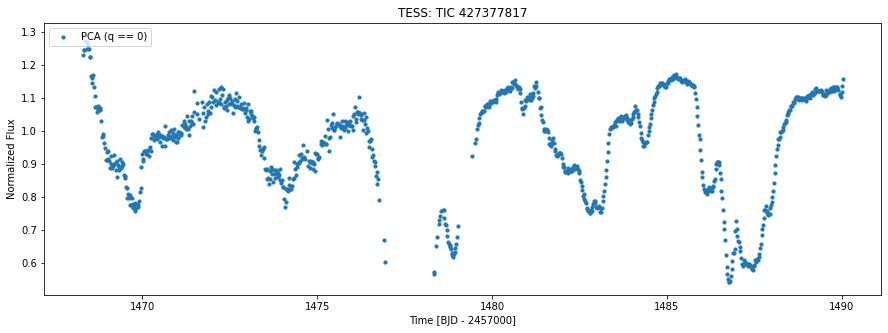

----------
GAIA
INFO: Query finished. [astroquery.utils.tap.core]

GAIA: 3217680887030421888
GAIA: Has epoch photometry.
The following Datalink product has been downloaded: * EPOCH_PHOTOMETRY-Gaia DR3 3217680887030421888.xml


/var/folders/7v/l452hfv10nz_81tzz2ycwbrr0000gn/T/ipykernel_1568/1884314845.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rp['magerr'] = np.divide(rp['flux_error'], rp['flux'])
/var/folders/7v/l452hfv10nz_81tzz2ycwbrr0000gn/T/ipykernel_1568/1884314845.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bp['magerr'] = np.divide(bp['flux_error'], bp['flux'])


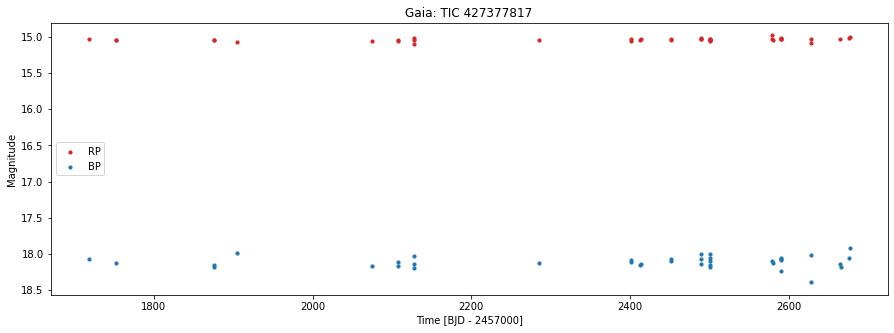

Index(['source_id', 'transit_id', 'band', 'time', 'mag', 'flux', 'flux_error',
       'flux_over_error', 'rejected_by_photometry', 'rejected_by_variability',
       'other_flags', 'solution_id', 'magerr'],
      dtype='object')


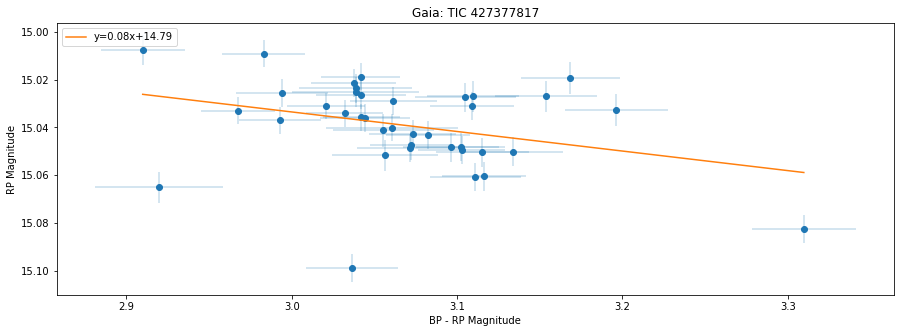

----------
ZTF
ZTF: 625 good observations found.


KeyboardInterrupt: 

In [20]:
if __name__ == "__main__":
    main()